In [1]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

2021-11-17 21:51:01.586153: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-17 21:51:01.586190: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
dataframe = pd.read_csv('data/lab1/krkopt.csv')
dataframe

,wh_king_file,wh_king_rank,wh_rook_file,wh_rook_rank,bl_king_file,bl_king_rank,res
0,a,1,b,3,c,2,draw
1,a,1,c,1,c,2,draw
2,a,1,c,1,d,1,draw
3,a,1,c,1,d,2,draw
4,a,1,c,2,c,1,draw
...,...,...,...,...,...,...,...
28051,b,1,g,7,e,5,sixteen
28052,b,1,g,7,e,6,sixteen
28053,b,1,g,7,e,7,sixteen
28054,b,1,g,7,f,5,sixteen


In [3]:
dataframe = dataframe.replace({
    "zero": 0,
    "one": 1,
    "two": 2,
    "three": 3,
    "four": 4,
    "five": 5,
    "six": 6,
    "seven": 7,
    "eight": 8,
    "nine": 9,
    "ten": 10,
    "eleven": 11,
    "twelve": 12,
    "thirteen": 13,
    "fourteen": 14,
    "fifteen": 15,
    "sixteen": 16,
    "draw": 17,
})
dataframe

,wh_king_file,wh_king_rank,wh_rook_file,wh_rook_rank,bl_king_file,bl_king_rank,res
0,a,1,b,3,c,2,17
1,a,1,c,1,c,2,17
2,a,1,c,1,d,1,17
3,a,1,c,1,d,2,17
4,a,1,c,2,c,1,17
...,...,...,...,...,...,...,...
28051,b,1,g,7,e,5,16
28052,b,1,g,7,e,6,16
28053,b,1,g,7,e,7,16
28054,b,1,g,7,f,5,16


In [4]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.25)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

16833 train examples
5611 validation examples
5612 test examples


In [5]:
def dataframe_to_dataset(dataframe, shuffle=True, batch_size=64):
  df = dataframe.copy()
  labels = dataframe.pop('res')
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

train_ds = dataframe_to_dataset(train)
val_ds = dataframe_to_dataset(val)
test_ds = dataframe_to_dataset(test, shuffle=False)

/tmp/ipykernel_2579/396088484.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}
2021-11-17 21:51:05.148047: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-17 21:51:05.148087: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-17 21:51:05.148123: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Arch): /proc/driver/nvidia/version does not exist
2021-11-17 21:51:05.149566: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to us

In [6]:
def get_normalization_layer(name, dataset):
  normalizer = layers.Normalization(axis=None)

  feature_ds = dataset.map(lambda x, y: x[name])
  normalizer.adapt(feature_ds)

  return normalizer

def get_category_encoding_layer(name, dataset, max_tokens=None):
  index = layers.StringLookup(max_tokens=max_tokens)

  feature_ds = dataset.map(lambda x, y: x[name])
  index.adapt(feature_ds)
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())
  
  return lambda feature: encoder(index(feature))

In [7]:
all_inputs = []
encoded_features = []

for column in ['wh_king_rank', 'wh_rook_rank', 'bl_king_rank']:
    numeric_col = tf.keras.Input(shape=(1,), name=column)
    normalization_layer = get_normalization_layer(column, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

for column in ['wh_king_file', 'wh_rook_file', 'bl_king_file']:
  categorical_col = tf.keras.Input(shape=(1,), name=column, dtype='string')
  encoding_layer = get_category_encoding_layer(name=column,
                                               dataset=train_ds,
                                               max_tokens=8)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

In [8]:
all_features = tf.keras.layers.concatenate(encoded_features)

p = 0.1

x = layers.Dense(512, activation="relu", bias_initializer="he_normal")(all_features)
d1 = layers.Dropout(p)(x)
x1 = layers.Dense(512, activation="relu", bias_initializer="he_normal")(d1)
d2 = layers.Dropout(p)(x1)
x2 = layers.Dense(1024, activation="relu", bias_initializer="he_normal")(d2)
output_layer = layers.Dense(18, activation="softmax")(x2)

model = Model(inputs=all_inputs, outputs=output_layer)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=30)

model.save('./models/_new')


Epoch 1/30
264/264 [==============================] - 3s 9ms/step - loss: 1.6411 - acc: 0.3886 - val_loss: 1.2620 - val_acc: 0.5072
Epoch 2/30
264/264 [==============================] - 2s 8ms/step - loss: 1.1717 - acc: 0.5440 - val_loss: 1.0632 - val_acc: 0.5680
Epoch 3/30
264/264 [==============================] - 2s 8ms/step - loss: 1.0111 - acc: 0.5970 - val_loss: 0.9370 - val_acc: 0.6295
Epoch 4/30
264/264 [==============================] - 2s 8ms/step - loss: 0.9054 - acc: 0.6320 - val_loss: 0.8799 - val_acc: 0.6525
Epoch 5/30
264/264 [==============================] - 2s 8ms/step - loss: 0.8127 - acc: 0.6711 - val_loss: 0.9109 - val_acc: 0.6409
Epoch 6/30
264/264 [==============================] - 2s 8ms/step - loss: 0.7803 - acc: 0.6825 - val_loss: 0.7294 - val_acc: 0.7116
Epoch 7/30
264/264 [==============================] - 2s 8ms/step - loss: 0.6771 - acc: 0.7261 - val_loss: 0.6893 - val_acc: 0.7189
Epoch 8/30
264/264 [==============================] - 2s 8ms/step - loss: 0.

2021-11-17 21:52:13.133188: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/k_init_he_normal/assets


Text(0.5, 1.0, 'Training and validation loss')

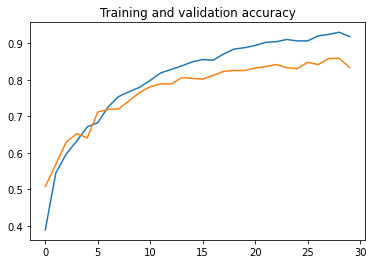

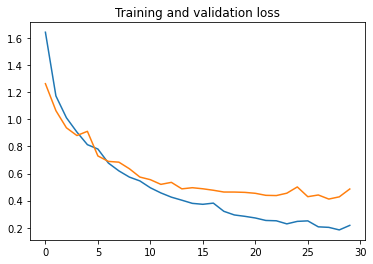

In [9]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')